# Task 4. Algorithms for unconstrained nonlinear optimization. Stochastic and metaheuristic algorithms
Alexandra Matveeva J4134c

In [58]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.optimize
from scipy import optimize, spatial
import pandas as pd
import os
import urllib.request
import math

In [59]:
eps = 1e-3
iter_max = 1000

In [60]:
def f_x(x):
  return 1 / (x**2 - 3 * x + 2)

In [61]:
# data generation

xk = []
yk = []

for k in range(1001):
  xk.append(3 * k / 1000)
  f = f_x(xk[k])
  if(f < -100):
    yk.append(-100 + np.random.normal(0, 1))
  elif (f >= -100 and f <= 100):
    yk.append(f + np.random.normal(0, 1))
  else:
    yk.append(100 + np.random.normal(0, 1))
xk = np.array(xk)
yk = np.array(yk)


In [62]:
def rational_approx(x, a, b, c, d):
  return (a * x + b) / (x ** 2 + c * x + d)

In [63]:
def D(params, yk, x):
  a, b, c, d = params

  return sum((rational_approx(x, a, b, c, d) - yk) ** 2)

In [64]:
# Nelder-Mead algorithm
nelderMead = scipy.optimize.minimize(D, [0.1, 0.1, 0.1, 0.1], args=(yk, xk), method='Nelder-Mead', tol=eps)

In [65]:
# Levenberg-Marquardt
def reseduals(params, yk, x): 
  a, b, c, d = params
  res = np.zeros(len(x))
  for i in range(len(x)):
    res[i] = (a * x[i] + b) / (x[i] ** 2 + c * x[i] + d) - yk[i]
  return res

lm = scipy.optimize.least_squares(reseduals, [0.1, 0.1, 0.1, 0.1], args=(yk, xk), method='lm', xtol=eps)

In [70]:
# Simulated Annealing
r_min, r_max = -5, 5

annealing = scipy.optimize.dual_annealing(D, ((r_min, r_max), (r_min, r_max), (r_min, r_max), (r_min, r_max)), args=(yk, xk))

In [67]:
# Differential Evolution

diff_evol = scipy.optimize.differential_evolution(D, ((r_min, r_max), (r_min, r_max), (r_min, r_max), (r_min, r_max)), args=(yk, xk), maxiter=1000)

In [71]:
# Reaults
print(f'Nelder-Mead method: {nelderMead.x} function evaluations: {nelderMead.nfev} iterations: {nelderMead.nit}')
print(f'Levenberg-Marquardt method: {lm.x} function evaluations: {lm.nfev}')
print(f'Simulated Annealing: {annealing.x} function evaluations: {annealing.nfev} iterations: {annealing.nit}')
print(f'Differential Evolution: {diff_evol.x} function evaluations: {diff_evol.nfev} iterations: {diff_evol.nit}')

Nelder-Mead method: [-0.77635305  0.77673564 -2.00095739  1.00096738] function evaluations: 493 iterations: 282
Levenberg-Marquardt method: [-1.0015689   1.00204634 -2.00088087  1.00089717] function evaluations: 183
Simulated Annealing: [-0.99865385  0.99915328 -2.00097239  1.00098857] function evaluations: 9116 iterations: 1000
Differential Evolution: [-0.99878812  0.99928753 -2.00097149  1.00098767] function evaluations: 1260 iterations: 4


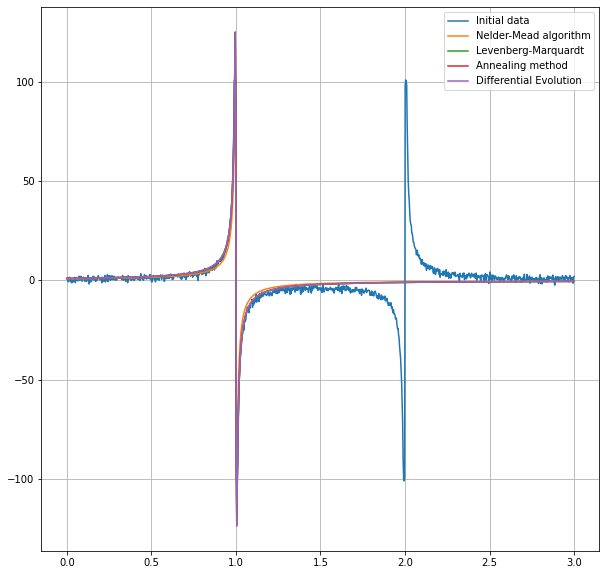

In [72]:
nelderMead_y = []
for k in range(1001):
  nelderMead_y.append((nelderMead.x[0] * xk[k] + nelderMead.x[1]) / (xk[k] ** 2 + nelderMead.x[2] * xk[k] + nelderMead.x[3]))

lm_y = []
for k in range(1001):
  lm_y.append((lm.x[0] * xk[k] + lm.x[1]) / (xk[k] ** 2 + lm.x[2] * xk[k] + lm.x[3]))

annealing_y = []
for k in range(1001):
  annealing_y.append((annealing.x[0] * xk[k] + annealing.x[1]) / (xk[k] ** 2 + annealing.x[2] * xk[k] + annealing.x[3]))  

diff_evol_y = []
for k in range(1001):
  diff_evol_y.append((diff_evol.x[0] * xk[k] + diff_evol.x[1]) / (xk[k] ** 2 + diff_evol.x[2] * xk[k] + diff_evol.x[3]))  


plt.figure(figsize=(10, 10))
plt.grid(True)
plt.plot(xk, yk)
plt.plot(xk, nelderMead_y)
plt.plot(xk, lm_y)
plt.plot(xk, annealing_y)
plt.plot(xk, diff_evol_y)
plt.legend(['Initial data', 'Nelder-Mead algorithm', 'Levenberg-Marquardt', 'Annealing method', 'Differential Evolution'])

II part

In [13]:
# Travelling Salesman Problem
# Simulated Annealing method

In [15]:
def initParameter():
    # custom function initParameter():
    # Initial parameter for simulated annealing algorithm
    tInitial = 100.0                # (initial temperature)
    tFinal  = 1                     # (stop temperature)
    nMarkov = 1000                  # Markov
    alfa    = 0.98                  # T(k)=alfa*T(k-1)

    return tInitial,tFinal,alfa,nMarkov

In [16]:
def calTourMileage(tourGiven, nCities, distMat):
    # custom function caltourMileage(nCities, tour, distMat):
    # to compute mileage of the given tour
    mileageTour = distMat[tourGiven[nCities-1], tourGiven[0]]   # dist((n-1),0)
    for i in range(nCities-1):                                  # dist(0,1),...dist((n-2)(n-1))
        mileageTour += distMat[tourGiven[i], tourGiven[i+1]]
    return round(mileageTour)   

In [17]:
def mutateSwap(tourGiven, nCities):
    # custom function mutateSwap(nCities, tourNow)
    # produce a mutation tour with 2-Swap operator
    # swap the position of two Cities in the given tour

    #  [0,n)  2 i,j
    i = np.random.randint(nCities)          #  [0,n) 
    while True:
        j = np.random.randint(nCities)      #  [0,n) 
        if i!=j: break                      #  i, j 

    tourSwap = tourGiven.copy()             #  tourSwap
    tourSwap[i],tourSwap[j] = tourGiven[j],tourGiven[i] #   i  j 

    return tourSwap

In [18]:
def plot_tour(tour, value, coordinates):
    # custom function plot_tour(tour, nCities, coordinates)

    num = len(tour)
    x0, y0 = coordinates[tour[num - 1]]
    x1, y1 = coordinates[tour[0]]
    plt.scatter(int(x0), int(y0), s=15, c='r')      #  C(n-1)
    plt.plot([x1, x0], [y1, y0], c='b')             #  C(n-1)~C(0)
    for i in range(num - 1):
        x0, y0 = coordinates[tour[i]]
        x1, y1 = coordinates[tour[i + 1]]
        plt.scatter(int(x0), int(y0), s=15, c='r')  #  C(i)
        plt.plot([x1, x0], [y1, y0], c='b')         #  C(i)~C(i+1)

    plt.xlabel("Total mileage of the tour:{:.1f}".format(value))
    plt.title("Optimization tour of TSP{:d}".format(num))  # 
    plt.show()

In [28]:
filename = 'kn57_xy.txt'
link = 'https://people.sc.fsu.edu/~jburkardt/datasets/cities/kn57_xy.txt'
if not os.path.exists(filename):
  urllib.request.urlretrieve(link, filename)


with open(filename) as input_file:
  data = input_file.readlines()[6:-1]

data = [line.strip() for line in data]
data = [line.split() for line in data]
data = np.array(data, dtype=float)
dist_matrix = spatial.distance.squareform(spatial.distance.pdist(data))

In [29]:
tInitial,tFinal,alfa,nMarkov = initParameter()  

In [30]:
nCities = data.shape[0]             #   nCities
nMarkov = nCities                   #   Markov 
tNow    = tInitial                  #   (current temperature)

In [31]:
tourNow   = np.arange(nCities)   # 01n 
valueNow  = calTourMileage(tourNow, nCities, dist_matrix) #  valueNow
tourBest  = tourNow.copy()                          #  tourNow
valueBest = valueNow                                #  valueNow
recordBest = []                                     #  
recordNow  = []                                     #

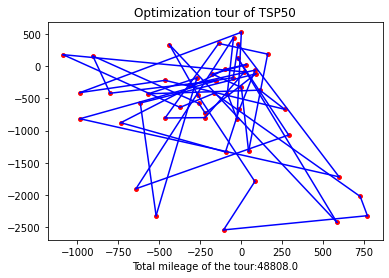

In [32]:
figure = plt.figure()     #  1
plot_tour(tourBest, valueBest, data)

i:0, t(i):100.00, valueNow:38761.0, valueBest:38761.0
i:1, t(i):98.00, valueNow:35874.0, valueBest:35874.0
i:2, t(i):96.04, valueNow:31865.0, valueBest:31865.0
i:3, t(i):94.12, valueNow:30704.0, valueBest:30704.0
i:4, t(i):92.24, valueNow:26987.0, valueBest:26987.0
i:5, t(i):90.39, valueNow:25797.0, valueBest:25581.0
i:6, t(i):88.58, valueNow:25896.0, valueBest:25581.0
i:7, t(i):86.81, valueNow:25393.0, valueBest:25393.0
i:8, t(i):85.08, valueNow:25550.0, valueBest:25393.0
i:9, t(i):83.37, valueNow:23806.0, valueBest:23806.0
i:10, t(i):81.71, valueNow:22649.0, valueBest:22649.0
i:11, t(i):80.07, valueNow:22447.0, valueBest:22436.0
i:12, t(i):78.47, valueNow:21949.0, valueBest:21807.0
i:13, t(i):76.90, valueNow:21977.0, valueBest:21722.0
i:14, t(i):75.36, valueNow:21593.0, valueBest:21593.0
i:15, t(i):73.86, valueNow:21583.0, valueBest:21481.0
i:16, t(i):72.38, valueNow:21618.0, valueBest:21481.0
i:17, t(i):70.93, valueNow:21021.0, valueBest:21021.0
i:18, t(i):69.51, valueNow:20551.0, v

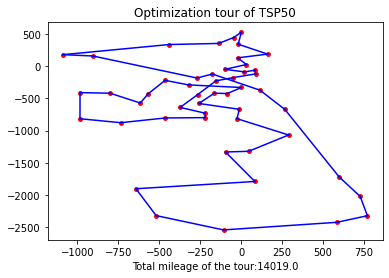

Tour verification successful!
Best tour: 
 [27 10  2 31 43 18  8 30 34  1  7 39 33 22 40 36 41 42 13 26 25  3 23 17
 45 37 49 32 29 12  0 35  4  5 46  9 20 11 15 38 44 19 47 48  6 14 28 16
 21 24]
Best value: 14019.0


In [33]:
iter = 0                        # 
while tNow >= tFinal:           # 
    # (nMarkov)

    for k in range(nMarkov):    # Markov
        # 
        tourNew = mutateSwap(tourNow, nCities)      #   
        # tourNew,deltaE = mutateSwapE(tourNow,nCities,distMat)   #    deltaE
        valueNew = calTourMileage(tourNew, nCities, dist_matrix) # 
        deltaE = valueNew - valueNow

        #  Metropolis 
        if deltaE < 0:                          # 
            accept = True
            if valueNew < valueBest:            # 
                tourBest[:] = tourNew[:]
                valueBest = valueNew
        else:                                   # 
            pAccept = math.exp(-deltaE/tNow)    # 
            if pAccept > random.random():
                accept = True
            else:
                accept = False

        # 
        if accept == True:                      # 
            tourNow[:] = tourNew[:]
            valueNow = valueNew

    #  0,n-1
    tourNow = np.roll(tourNow,2)                # 

    # 
    recordBest.append(valueBest)                #  
    recordNow.append(valueNow)                  #  
    print('i:{}, t(i):{:.2f}, valueNow:{:.1f}, valueBest:{:.1f}'.format(iter,tNow,valueNow,valueBest))

    # 
    iter = iter + 1
    tNow = tNow * alfa                              # T(k)=alfa*T(k-1)

# 

# 
figure1 = plt.figure()     #  1
plot_tour(tourBest, valueBest, data)


print("Tour verification successful!")
print("Best tour: \n", tourBest)
print("Best value: {:.1f}".format(valueBest))